In [1]:

import matplotlib.pyplot as plt
import os
import scipy.io
import cv2
import random
from sklearn.utils import shuffle
import random
from collections import Counter
import os
import random
import numpy as np
import tensorflow as tf
    
# 1. Set seed
# SEED = np.random.seed()
SEED = 42 # try with seed 42
# 2. Python built-in
random.seed(SEED)

# 3. NumPy
np.random.seed(SEED)

# 4. TensorFlow
tf.random.set_seed(SEED)


2025-05-04 17:31:55.930551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746379915.952964    3307 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746379915.959798    3307 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from platform import python_version
print(python_version())

import tensorflow as tf
print(tf.__version__)

3.11.11
2.18.0


In [3]:
# Load training data
data = np.load("/kaggle/input/7x7-patches/spectral_patches_7x7.npz") 
X_train = data["X_train"]
Y_train = data["Y_train"]


X_test = data["X_test"]
Y_test = data["Y_test"]

core_ids = data["core_ids"]
X_train = X_train[..., np.newaxis]  # (20000, 7, 7, 1)
X_test = X_test[..., np.newaxis]

print("Data loaded successfully!")
print("X_train shape:", X_train.shape, "Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape, "Y_test shape:", Y_test.shape)
print("core_ids:", core_ids.shape)


Data loaded successfully!
X_train shape: (20000, 7, 7, 558, 1) Y_train shape: (20000,)
X_test shape: (14403, 7, 7, 558, 1) Y_test shape: (14403,)
core_ids: (20000,)


In [4]:
print(Counter(Y_test))

Counter({0: 9693, 1: 4710})


In [5]:

# Trying data augmentation. Decided not to use after balancing dataset during patch extraction
# aug_indices = np.random.choice(len(X_train), size=int(0.3 * len(X_train)), replace=False)
# X_augment = X_train[aug_indices]
# Y_augment = Y_train[aug_indices]
# core_ids_augment = core_ids[aug_indices]

# def augment_patches(patches):
#     # Flatten spectral+channel dimension into one channel (reshape to 4D)
#     shape = patches.shape
#     X_reshaped = tf.reshape(patches, [-1, shape[1], shape[2], shape[3]*shape[4]])

#     # Apply 2D augmentations
#     X_aug = tf.image.random_flip_left_right(X_reshaped)
#     X_aug = tf.image.random_flip_up_down(X_aug)
#     # X_aug = tf.image.random_brightness(X_aug, max_delta=0.1)

#     # Reshape back to original (5D)
#     X_restored = tf.reshape(X_aug, shape)
#     return X_restored.numpy()

# X_aug = augment_patches(X_augment)
# X_train = np.concatenate([X_train, X_aug])
# Y_train = np.concatenate([Y_train, Y_augment])
# core_ids = np.concatenate([core_ids, core_ids_augment])


## Spatial attention module

In [6]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import mixed_precision
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D, Dense, Dropout, BatchNormalization, MaxPooling3D, GlobalMaxPooling3D,
    Input, GlobalAveragePooling3D, Flatten, LayerNormalization, SpatialDropout3D, RandomFlip, RandomRotation, Concatenate, Reshape, Lambda, Multiply, Add, Activation

)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


# --- Mixed Precision ---
mixed_precision.set_global_policy('mixed_float16')

## CBAM spatial

In [7]:
def cbam_spatial_attention(input_tensor):
    # Compute max and avg along channel axis
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(input_tensor)

    # Concatenate along channel axis
    concat = Concatenate(axis=-1)([avg_pool, max_pool])  # shape: (D, H, W, 2)

    # Get spatial attention map
    cbam_feature = Conv3D(filters=1, kernel_size=3, padding='same', activation='sigmoid', use_bias=False, kernel_regularizer=l2(5e-4))(concat)

    # Multiply with weights
    return Multiply()([input_tensor, cbam_feature])

## CBAM channel

In [8]:

def cbam_channel_attention(input_tensor):
    channel = input_tensor.shape[-1]

    # Global Average Pooling
    avg_pool = GlobalAveragePooling3D()(input_tensor)
    avg_pool = Reshape((1, 1, 1, channel))(avg_pool)

    # Global Max Pooling
    max_pool = GlobalMaxPooling3D()(input_tensor)
    max_pool = Reshape((1, 1, 1, channel))(max_pool)

    # Shared MLP
    shared_mlp = Dense(channel // 32, activation='relu', use_bias=False)
    shared_out_avg = shared_mlp(avg_pool)
    shared_out_max = shared_mlp(max_pool)

    shared_out_avg = Dense(channel, use_bias=False)(shared_out_avg)
    shared_out_max = Dense(channel, use_bias=False)(shared_out_max)

    # Combine
    cbam_feature = Add()([shared_out_avg, shared_out_max])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    # Scale input
    return Multiply()([input_tensor, cbam_feature])


## CBAM Hybrid

In [9]:
# Hybrid combiens channel and spatial 
def cbam_block(input_tensor):
    x = cbam_channel_attention(input_tensor)
    x = cbam_spatial_attention(x)
    return x


## Baseline 3D CNN

In [10]:


def build_model(input_shape, attention = None):
    inputs = Input(shape=input_shape)

    # conv1 
    x = Conv3D(16, kernel_size=(3, 3, 7), strides=(1,1,2),
               activation='relu', padding='same')(inputs)
    x = LayerNormalization()(x)

    # conv2
    x = Conv3D(32, (3, 3, 5), activation='relu',
               padding='same', kernel_regularizer=l2(1e-4))(x)
    x = LayerNormalization()(x)
    if attention =='channel':
        x = cbam_channel_attention(x)
    elif attention == 'spatial':
        x = cbam_spatial_attention(x)
    elif attention == 'cbam':
        x = cbam_block(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = SpatialDropout3D(0.4)(x)

    # conv3
    x = Conv3D(32, (3, 3, 3), activation='relu',
               padding='same', kernel_regularizer=l2(1e-4))(x)
    x = LayerNormalization()(x)


    # head
    x = GlobalAveragePooling3D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss=BinaryCrossentropy(label_smoothing=0.05),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )

    return model




In [11]:
from collections import defaultdict

# Map core to majority label and sample count, greedy approach
# Ensures that each fold has representation from both classes

def stratified_core_split(core_ids, labels, n_splits=5, random_state=SEED):
    np.random.seed(random_state)

    # Group indices by core
    core_to_indices = defaultdict(list)
    for i, core in enumerate(core_ids):
        core_to_indices[core].append(i)

    core_stats = []
    for core, idxs in core_to_indices.items():
        label = int(labels[idxs[0]])
        count = len(idxs)
        core_stats.append((core, label, count))  

    # Separate cancer and normal cores
    cancer_cores = [stat for stat in core_stats if stat[1] == 1]
    normal_cores = [stat for stat in core_stats if stat[1] == 0]

    def balance_folds(core_list):
        # Sort by descending patch count
        core_list = sorted(core_list, key=lambda x: x[2], reverse=True)
        folds = [[] for _ in range(n_splits)]
        fold_counts = [0] * n_splits

        for core, label, count in core_list:
            # Assign to fold with least total so far
            i = np.argmin(fold_counts)
            folds[i].append(core)
            fold_counts[i] += count

        return folds

    # Create balanced folds by sample count
    cancer_folds = balance_folds(cancer_cores)
    normal_folds = balance_folds(normal_cores)

    # Merge into final folds
    final_folds = []
    for i in range(n_splits):
        val_cores = cancer_folds[i] + normal_folds[i]
        train_cores = list(set(core_to_indices.keys()) - set(val_cores))

        train_idx = [i for core in train_cores for i in core_to_indices[core]]
        val_idx = [i for core in val_cores for i in core_to_indices[core]]
        final_folds.append((np.array(train_idx), np.array(val_idx)))

    return final_folds


## 5 Fold Cross Validation 

In [12]:
import time

# Metrics 
accs, precisions, recalls, f1s, kappas, aucs, aas = [], [], [], [], [], [],[]
val_losses, val_accuracies = [], []
thresholds = []

# Stratified group k-fold cross-validation
folds = stratified_core_split(core_ids, Y_train, n_splits=5, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(folds, 1):
    print(f"\n--- Fold {fold} ---")
    start_time = time.time()

    X_train_fold = X_train[train_idx]
    Y_train_fold = Y_train[train_idx]

    X_val_fold = X_train[val_idx]
    Y_val_fold = Y_train[val_idx]

    print("Classes in train fold: ",Counter(Y_train_fold))
    print("Classes in val fold: ", Counter(Y_val_fold))

    model = build_model((7, 7, 558, 1))
    # model = build_model((7, 7, 558, 1),attention='spatial')

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=6, min_delta=1e-3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=3, min_lr=1e-6)

    class_weights = {0: 1.0, 1:2.5}

    history = model.fit(
        X_train_fold, Y_train_fold,
        validation_data=(X_val_fold, Y_val_fold),
        epochs=40,
        batch_size=16,
        verbose=0,
        class_weight=class_weights,
        callbacks=[early_stop, reduce_lr]
    )


    # Extract final val_loss and val_accuracy from training history
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Threshold tuning, based on 
    val_probs = model.predict(X_val_fold).flatten()
    best_f1, best_thresh = 0, 0.5
    for t in np.linspace(0.25, 0.55, 50):
        preds = (val_probs >= t).astype(int)
        score = f1_score(Y_val_fold, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = t
    thresholds.append(best_thresh)

    final_preds = (val_probs >= best_thresh).astype(int)

    acc = accuracy_score(Y_val_fold, final_preds)
    prec = precision_score(Y_val_fold, final_preds, zero_division=0)
    rec = recall_score(Y_val_fold, final_preds, zero_division=0)
    f1 = f1_score(Y_val_fold, final_preds, zero_division=0)
    kappa = cohen_kappa_score(Y_val_fold, final_preds) if len(np.unique(Y_val_fold)) > 1 and len(np.unique(final_preds)) > 1 else float('nan')
    auc = roc_auc_score(Y_val_fold, val_probs)
    aa = recall_score(Y_val_fold, final_preds, average='macro')

    accs.append(acc); precisions.append(prec); recalls.append(rec); f1s.append(f1); kappas.append(kappa); aucs.append(auc); aas.append(aa)

    print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")
    print(f"Metrics → Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, Kappa: {kappa:.4f}, AUC: {auc:.4f}, Threshold: {best_thresh:.2f}")
    end_time = time.time()
    print(f"Execution time: {(end_time - start_time):.2f} seconds")
# --- Summary ---
print("\nCross-Validation Summary:")
print(f"Mean Accuracy:      {np.mean(accs):.4f} +/- {np.std(accs):.4f}")
print(f"Mean Precision:     {np.mean(precisions):.4f} +/- {np.std(precisions):.4f}")
print(f"Mean Recall:        {np.mean(recalls):.4f} +/- {np.std(recalls):.4f}")
print(f"Mean F1 Score:      {np.mean(f1s):.4f} +/- {np.std(f1s):.4f}")
print(f"Mean Kappa:         {np.nanmean(kappas):.4f} +/- {np.nanstd(kappas):.4f}")
print(f"Mean AUC:           {np.mean(aucs):.4f} +/- {np.std(aucs):.4f}")
print(f"Mean AA (Avg Acc):   {np.mean(aas):.4f} +/- {np.std(aas):.4f}")
print(f"Mean Val Accuracy:  {np.mean(val_accuracies):.4f} +/- {np.std(val_accuracies):.4f}")
print(f"Mean Val Loss:      {np.mean(val_losses):.4f} +/- {np.std(val_losses):.4f}")



final_thresh = np.mean(thresholds)
print(f"Final threshold (mean from CV): {final_thresh:.2f}")



--- Fold 1 ---
Classes in train fold:  Counter({0: 8534, 1: 7984})
Classes in val fold:  Counter({1: 2016, 0: 1466})


I0000 00:00:1746379942.382320    3307 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746379942.382990    3307 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1746379952.478321    3359 service.cc:148] XLA service 0x7d58d4006d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746379952.478368    3359 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746379952.478374    3359 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746379953.001602    3359 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746379958.122449    3359 device_compiler.h:188] Compiled clust

109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Validation Accuracy: 0.8136, Validation Loss: 0.4892
Metrics → Accuracy: 0.8265, Precision: 0.9663, Recall: 0.7257, F1: 0.8289, Kappa: 0.6601, AUC: 0.8190, Threshold: 0.47
Execution time: 284.95 seconds

--- Fold 2 ---
Classes in train fold:  Counter({0: 8563, 1: 8004})
Classes in val fold:  Counter({1: 1996, 0: 1437})
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Validation Accuracy: 0.6353, Validation Loss: 0.6233
Metrics → Accuracy: 0.6006, Precision: 0.5959, Recall: 0.9729, F1: 0.7391, Kappa: 0.0644, AUC: 0.8041, Threshold: 0.27
Execution time: 162.67 seconds

--- Fold 3 ---
Classes in train fold:  Counter({0: 8436, 1: 8006})
Classes in val fold:  Counter({1: 1994, 0: 1564})
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Validation Accuracy: 0.7203, Validation Loss: 0.5464
Metrics → Accuracy: 0.7544, Precision: 0.8207, Recall: 0.7187, F1: 0.7663, Kappa: 0.5098, AUC: 0.8400, Threshold: 0.54
Execution time: 193.41 seconds

--- Fold 4 ---
Classes in tr

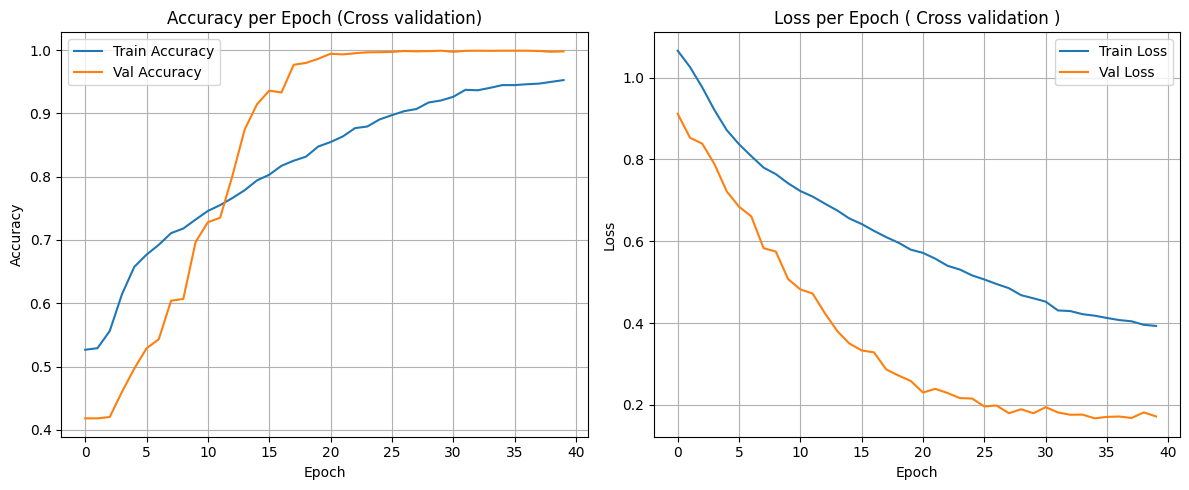

In [13]:
# Plot Training Metrics for one of the folds - just for validation
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy per Epoch (Cross validation)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch ( Cross validation )")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Final model with test set

Epoch 1/40
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.4495 - auc: 0.5559 - loss: 1.0742 - precision: 0.4452 - recall: 0.9750 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.3729 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/40
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.4755 - auc: 0.7362 - loss: 0.9998 - precision: 0.4579 - recall: 0.9869 - val_accuracy: 0.9986 - val_auc: 0.0000e+00 - val_loss: 0.3578 - val_precision: 1.0000 - val_recall: 0.9986 - learning_rate: 1.0000e-05
Epoch 3/40
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5275 - auc: 0.8091 - loss: 0.9492 - precision: 0.4841 - recall: 0.9752 - val_accuracy: 0.9953 - val_auc: 0.0000e+00 - val_loss: 0.3408 - val_precision: 1.0000 - val_recall: 0.9953 - learning_rate: 1.0000e-05
Epoch 4/40
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.6004 - auc: 0.8626 - loss: 0.8877 - precision: 0.5274 - recall: 0.9620 - val_accuracy: 0.9860 - 

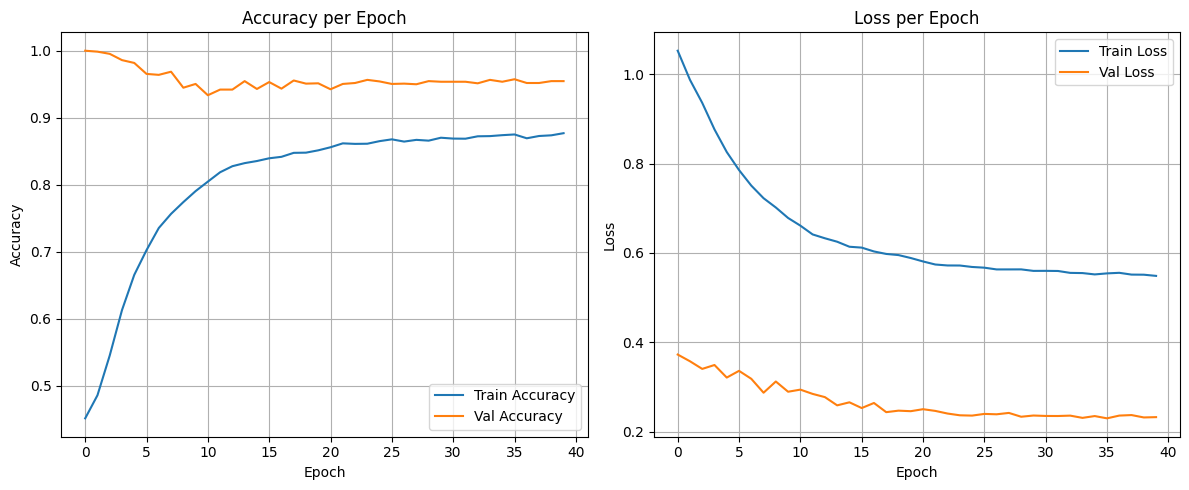

451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

Test Accuracy:  0.8663
Test Precision: 0.8454
Test Recall:    0.7236
Test F1 Score:  0.7798
Test AUC:      0.8847
Test AA (Avg Accuracy): 0.8296
Test Kappa:     0.6847
Execution time: 498.81 seconds


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import time

start_time = time.time()
# Stratified Group Split for Final Model Training 
sgkf_final = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
train_idx_final, val_idx_final = next(sgkf_final.split(X_train, Y_train, groups=core_ids))


X_train_final = X_train[train_idx_final]
Y_train_final = Y_train[train_idx_final]
X_val_final = X_train[val_idx_final]
Y_val_final = Y_train[val_idx_final]

# Build & Train Final Model
final_model = build_model((7, 7, 558, 1), attention='channel')
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=6,  min_delta=1e-3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=3, min_lr=1e-6)
class_weights = {0: 1.0, 1:2.5}

# Train model & save history
final_history = final_model.fit(
    X_train_final, Y_train_final,
    validation_data=(X_val_final, Y_val_final),
    epochs=40,
    class_weight=class_weights,
    batch_size=16,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Plot Training Metrics
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Train Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# --- Test Set Evaluation ---
test_probs = final_model.predict(X_test).flatten()
test_preds = (test_probs >= final_thresh).astype(int)


# --- Final Report ---
print(f"\nTest Accuracy:  {accuracy_score(Y_test, test_preds):.4f}")
print(f"Test Precision: {precision_score(Y_test, test_preds):.4f}")
print(f"Test Recall:    {recall_score(Y_test, test_preds):.4f}")
print(f"Test F1 Score:  {f1_score(Y_test, test_preds):.4f}")
print(f"Test AUC:      {roc_auc_score(Y_test, test_probs):.4f}")
print(f"Test AA (Avg Accuracy): {recall_score(Y_test, test_preds, average='macro'):.4f}")
print(f"Test Kappa:     {cohen_kappa_score(Y_test, test_preds):.4f}")


end_time = time.time()
print(f"Execution time: {(end_time - start_time):.2f} seconds")

## Confusion matrix

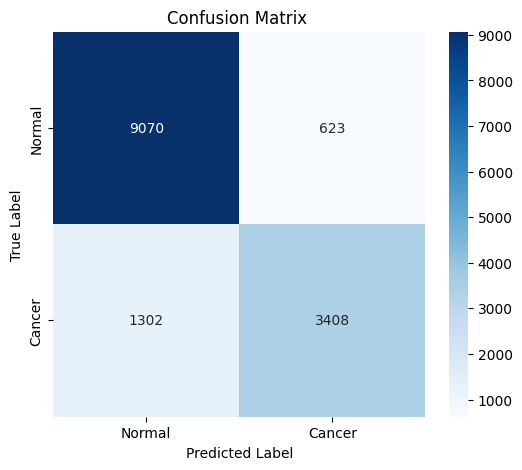

Classification Report:
               precision    recall  f1-score   support

      Normal       0.87      0.94      0.90      9693
      Cancer       0.85      0.72      0.78      4710

    accuracy                           0.87     14403
   macro avg       0.86      0.83      0.84     14403
weighted avg       0.86      0.87      0.86     14403



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(Y_test, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Cancer"], yticklabels=["Normal", "Cancer"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix ")


plt.show()

# Classification Report (Precision, Recall, F1-score)
print("Classification Report:\n", classification_report(Y_test, test_preds, target_names=["Normal", "Cancer"]))


